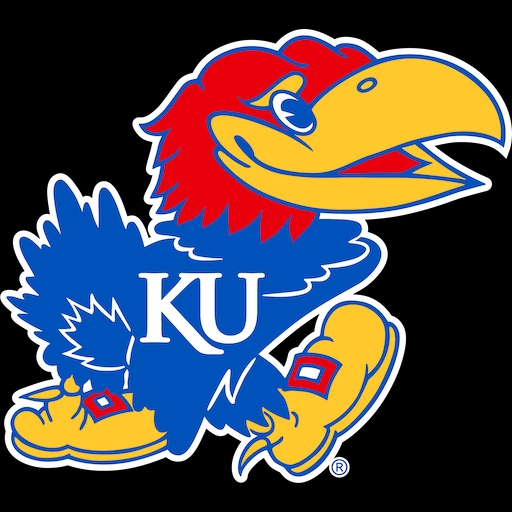

In [167]:
from pathlib import Path
from PIL import Image
import numpy as np
from sympy import Matrix

filename = Path("../img/color/Jayhawk_512x512x3.jpg")

with Image.open(filename, "r") as im:
    display(im)
    tmp = np.asarray(im, dtype=float)

# True for noisy execution, False for noise_free execution
noisy_execution = True
draw_qc = True


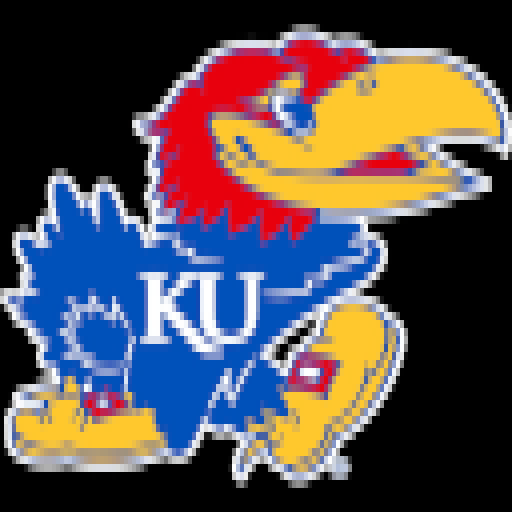

In [168]:
from qcc.cli.pooling import classical_average_pooling, classical_euclidean_pooling, reconstruction

decomposition_levels = [3, 2]
x = classical_euclidean_pooling(tmp, decomposition_levels)
x = reconstruction(x, decomposition_levels)
x = Image.fromarray(np.abs(x).astype(np.uint8))

display(x)


In [169]:
def display_quantum_circuit(qc):
    if draw_qc:
        display(qc.draw('mpl', reverse_bits=True))
        
def display_matrix(matrix):
    try:
        display(Matrix(matrix))
    except:
        print(matrix)


In [170]:
from qcc.quantum import flatten_image, normalize, to_qubits

psi, *dims = flatten_image(filename, pad=True)
psi, mag = normalize(psi, include_magnitude=True)

dims_q = [to_qubits(x) for x in dims]

num_qubits = sum(dims_q)
num_states = 2**num_qubits


In [171]:
from itertools import zip_longest

decomposition_levels = [1, 1]
dims_out = [d // (2**l) for d, l in zip_longest(dims, decomposition_levels, fillvalue=0)]

dims_out


[256, 256, 3]

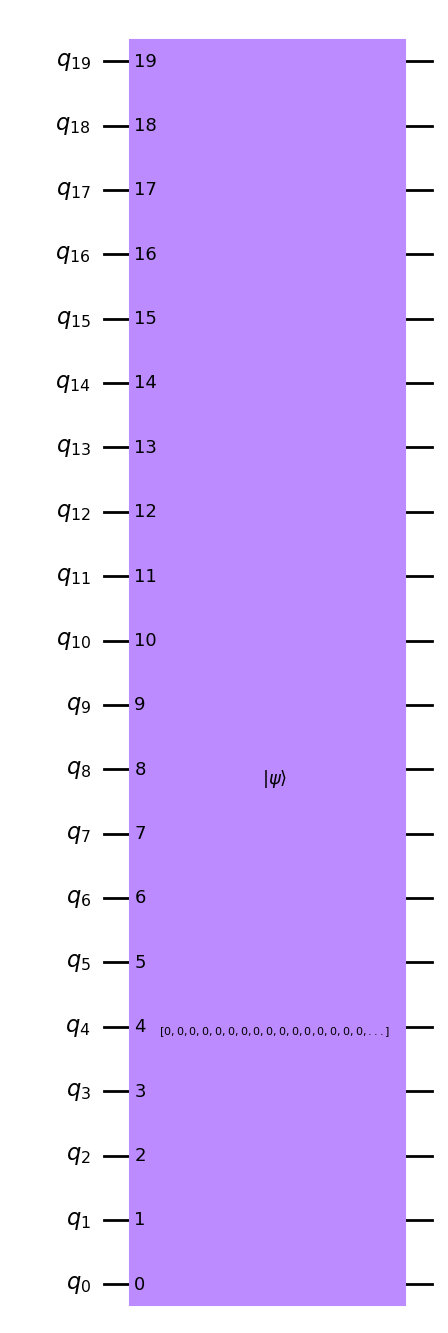

In [172]:
from qiskit import QuantumCircuit
from qiskit.quantum_info.operators import Operator

qc = QuantumCircuit(num_qubits)
qc.initialize(psi)

display_quantum_circuit(qc)


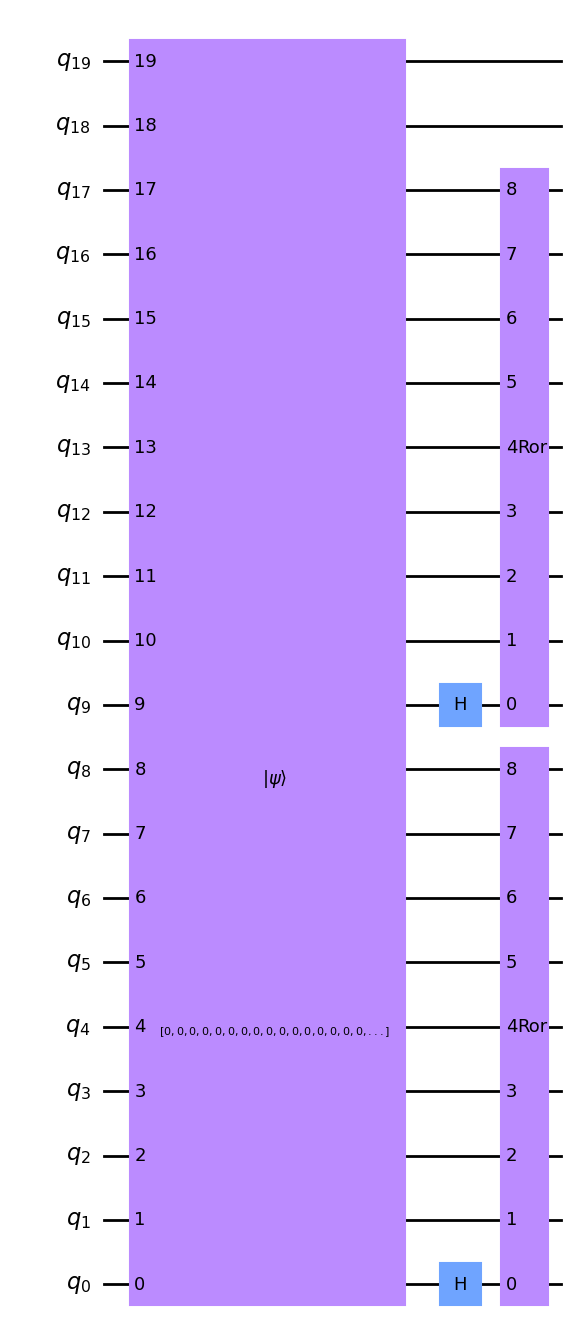

In [173]:
from qcc.quantum.qiskit.qht import QuantumHaarTransform

qht = QuantumHaarTransform(dims, decomposition_levels)
qc.compose(qht, inplace=True)

display_quantum_circuit(qc.decompose(QuantumHaarTransform))

In [174]:
from qcc.quantum.qiskit import exec_qc

psi_out = exec_qc(qc, noisy_execution=noisy_execution, shots=32000)

In [175]:
from qcc.quantum import reconstruct

img = psi_out.data
norm = mag / np.sqrt(2**sum(decomposition_levels))

print(min(np.abs(norm*img)), max(np.abs(norm*img)))


0.0 752.9958514888212


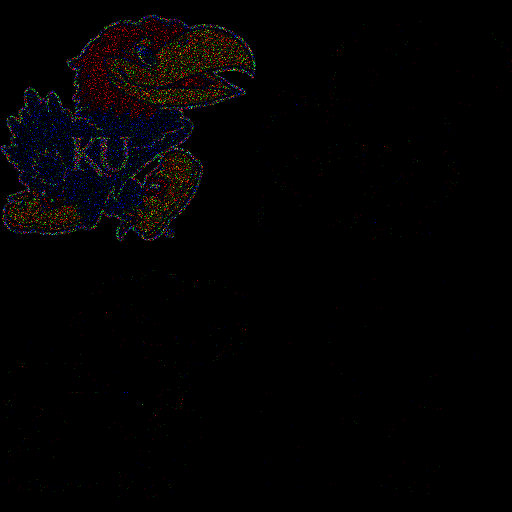

In [176]:
img_full = reconstruct(norm*img, dims)
img_full = Image.fromarray(np.abs(img_full).astype(np.uint8))
img_full.save("output_full.png")

display(img_full)


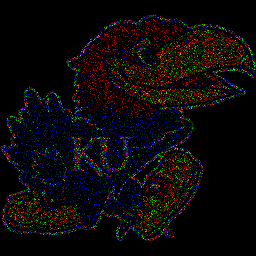

In [177]:
img_decomposed = reconstruct(norm*img, dims, dims_out)
img_decomposed = Image.fromarray(np.abs(img_decomposed).astype(np.uint8))
img_decomposed.save("output_decomposed.png")

display(img_decomposed)


### Quantum Reconstruction

In [178]:
# qc = qc.copy_empty_like()

# psi_new, *_ = flatten_image(img_decomposed, pad=True)
# psi_new, _ = normalize(psi_new, include_magnitude=True)


In [179]:
# initialize = []
# h = []
# for q, t, l in zip_longest(base, top, decomposition_levels, fillvalue=0):
#     h += qc.qubits[q:q+l]
#     initialize += qc.qubits[q+l:t]
    
# qc.initialize(psi_new, initialize)
# qc.h(h)

# display_quantum_circuit(qc)


In [180]:
# if noisy_execution:
#     qc.measure_all()
# else:
#     qc.save_statevector()

# job = execute(qc, backend=backend, shots=shots)
# job_monitor(job)

# result = job.result()

# if noisy_execution:
#     counts = result.get_counts(qc)
#     psi_out = from_counts(counts, shots=shots, num_qubits=num_qubits)
# else:
#     psi_out = result.get_statevector(qc).data


In [181]:
# img_reconstructed = reconstruct(mag*psi_out.data, dims)
# img_reconstructed = Image.fromarray(np.abs(img_reconstructed).astype(np.uint8))
# img_reconstructed.save("output_reconstructed.png")

# display(img_reconstructed)


### Classical Results

(256, 256, 3) 0.0 255.0


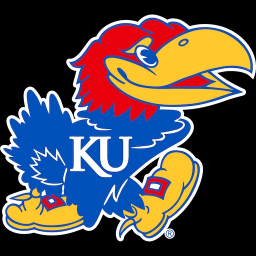

In [182]:
from pywt import wavedecn

with Image.open(filename, "r") as im:
    classical_img = np.asarray(im, dtype=float)

for i, l in enumerate(decomposition_levels):
    classical_img = wavedecn(classical_img, "haar", "zero", level=l, axes=i)
    classical_img = classical_img[0] / np.sqrt(2**l)
    
print(classical_img.shape, min(classical_img.flatten()), max(classical_img.flatten()))
    
classical_img = classical_img.astype(np.uint8)
classical_img = Image.fromarray(classical_img)
display(classical_img)
classical_img.save("output_classical.png")


In [183]:
# from pywt import waverecn

# with Image.open(filename, "r") as im:
#     classical_img = np.asarray(im, dtype=float)

# for i, l in enumerate(decomposition_levels):
#     details = ([s * (j+1) if i == k else s for k, s in enumerate(classical_img.shape)] for j in range(l))
#     details = (dict(d=np.zeros(shape)) for shape in details)
    
#     classical_img = [classical_img, *details]
#     classical_img = waverecn(classical_img, "haar", "zero", axes=i) * np.sqrt(2**l)
    
# classical_img = classical_img.astype(np.uint8)
# classical_img = Image.fromarray(classical_img)
# display(classical_img)
# classical_img.save("output_classical.png")


In [184]:
from qcc.quantum import get_fidelity

fid = get_fidelity(np.asarray(classical_img).flatten(), np.asarray(img_decomposed).flatten())

print(f"Fidelity: {fid:.03%}")


Fidelity: 26.900%
